# Klasifikasi Gambar dengan JAX, Flax NNX, dan Grain

Notebook ini mendemonstrasikan cara membangun arsitektur dan pelatihan model klasifikasi gambar ujung-ke-ujung (end-to-end) menggunakan ekosistem JAX modern:
*   **JAX**: Untuk komputasi berperforma tinggi.
*   **Flax NNX**: API terbaru dari Flax untuk definisi model yang lebih intuitif.
*   **Grain**: Library *data loading* dari Google yang didesain untuk kecepatan dan skalabilitas.

Kita akan melatih model *Feed-Forward Neural Network* / *Multilayer Perceptron* sederhana untuk mengenali digit tulisan tangan dari dataset MNIST.


### Langkah 1: Persiapan Environment & Module Lokal
Mulai dengan mengimpor library yang diperlukan. Perhatikan penggunaan `sys.path.append` untuk memastikan module lokal seperti `viz_utils` dan `train_utils` dapat diakses.


In [14]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from time import process_time
from IPython import display

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np
import grain.python as grain
from sklearn.datasets import fetch_openml

# My own modules
import viz_utils as vu
from plot_lib import set_default
import train_utils as tu

import importlib
importlib.reload(tu)

set_default()

### Langkah 2: Mengambil Dataset MNIST (Tanpa TensorFlow)
Untuk menghindari ketergantungan pada TensorFlow Datasets (TFDS) yang berat, kita menggunakan `scikit-learn` untuk mengunduh MNIST secara langsung dari OpenML. Data kemudian dikemas dalam kelas `MNISTSource` yang kompatibel dengan **Grain**.


In [ ]:
# Constants
DATA_DIR = "../data"
MODEL_DIR = "models"

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
LAMBDA_L2 = 1e-5

SEED = 42

In [16]:
# Load MNIST using scikit-learn to avoid tensorflow extraction issues
print("Loading MNIST via OpenML (may take a minute)...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X_all, y_all = mnist.data, mnist.target.astype(np.int32)

# Split into train and test (60k / 10k)
X_train, X_test = X_all[:60000], X_all[60000:]
y_train, y_test = y_all[:60000], y_all[60000:]

class MNISTSource(grain.RandomAccessDataSource):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
        
    def __len__(self):
        return len(self._images)
        
    def __getitem__(self, index):
        # MNIST in OpenML is flattened (784,)
        # Reshape to (1, 28, 28) and normalize to [0, 1]
        image = self._images[index].reshape(1, 28, 28).astype(np.float32) / 255.0
        label = self._labels[index]
        return {'image': image, 'label': label}

train_source = MNISTSource(X_train, y_train)
test_source = MNISTSource(X_test, y_test)
print(f"Train size: {len(train_source)}, Test size: {len(test_source)}")

Loading MNIST via OpenML (may take a minute)...
Train size: 60000, Test size: 10000


In [17]:
num_classes = 10
print(f"num_classes: {num_classes}")

num_classes: 10


### Langkah 3: Membangun Data Pipeline dengan Grain
Di sini kita mendefinisikan fungsi `create_loader`. Fungsi ini menggunakan `grain.IndexSampler` untuk pengaturan shuffling dan `grain.DataLoader` untuk memuat data. Kita juga menambahkan `BatchIterator` agar output batch berupa tuple NumPy array yang mudah digunakan dalam loop pelatihan.


In [ ]:
# Create Grain data loaders
def create_loader(source, batch_size, shuffle):
    sampler = grain.IndexSampler(
        num_records=len(source),
        num_epochs=1,
        shuffle=shuffle,
        seed=SEED,
    )
    loader = grain.DataLoader(
        data_source=source,
        sampler=sampler,
        worker_count=0, # Use 0 for simple local execution
    )
    
    # Convert record dictionaries to tuples for multi-assignment
    class BatchIterator:
        def __init__(self, loader, batch_size, num_records):
            self.loader = loader
            self.batch_size = batch_size
            self.num_records = num_records
        
        def __len__(self):
            return (self.num_records + self.batch_size - 1) // self.batch_size

        def __iter__(self):
            batch_images = []
            batch_labels = []
            for record in self.loader:
                batch_images.append(record['image'])
                batch_labels.append(record['label'])
                if len(batch_images) == self.batch_size:
                    yield np.stack(batch_images), np.array(batch_labels)
                    batch_images = []
                    batch_labels = []
            if batch_images:
                 yield np.stack(batch_images), np.array(batch_labels)
    
    return BatchIterator(loader, batch_size, len(source))

train_dataloader = create_loader(train_source, BATCH_SIZE, shuffle=True)

# Peek the batched data
for ib, (X_batch, y_batch) in enumerate(train_dataloader):
    print(f"[{ib}] Shape of X [N, C, H, W]: {X_batch.shape}")
    print(f"[{ib}] Shape of y: {y_batch.shape}, {y_batch.dtype}")
    # break

[0] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[0] Shape of y: (128,), int32
[1] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[1] Shape of y: (128,), int32
[2] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[2] Shape of y: (128,), int32
[3] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[3] Shape of y: (128,), int32
[4] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[4] Shape of y: (128,), int32
[5] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[5] Shape of y: (128,), int32
[6] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[6] Shape of y: (128,), int32
[7] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[7] Shape of y: (128,), int32
[8] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[8] Shape of y: (128,), int32
[9] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[9] Shape of y: (128,), int32
[10] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[10] Shape of y: (128,), int32
[11] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[11] Shape of y: (128,), int32
[12] Shape of X [N, C, H, W]: (128, 1, 28, 28)
[12] Shape of y: (128,), int32
[13] S

### Langkah 4: Inspeksi Visual Dataset
Sebelum melatih model, sangat penting untuk melihat sampel data. Kita menggunakan utilitas visualisasi untuk menampilkan beberapa digit MNIST dari batch pertama.


img_np : 0.0 1.0


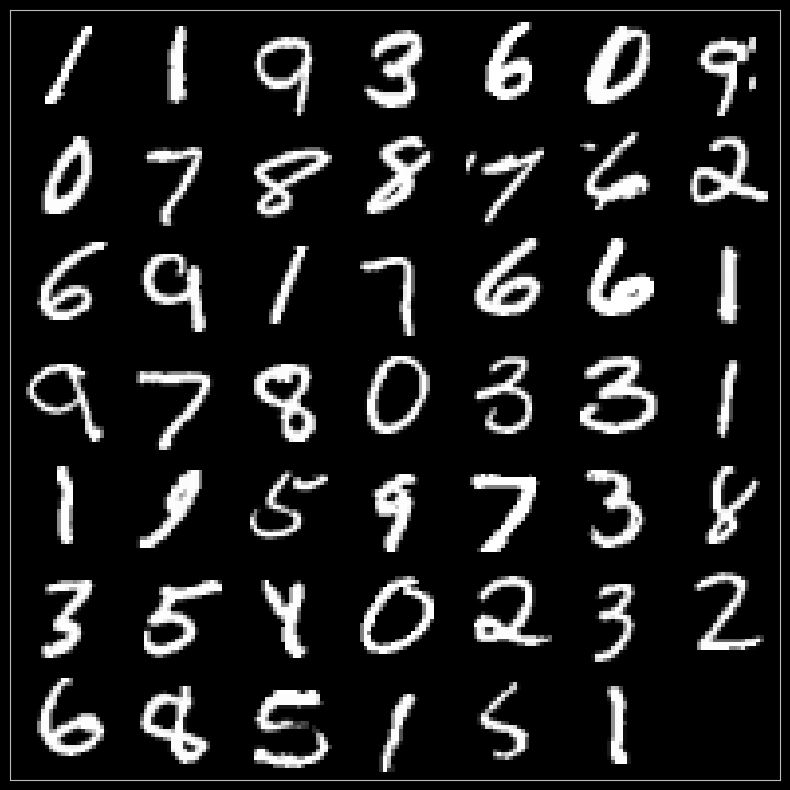

In [26]:
# Show training samples
grid = vu.set_grid(X_batch[:48], num_cells=48)
vu.show(grid)

### Langkah 5: Definisi Arsitektur Model (Flax NNX)
Kita mendefinisikan `FFNet` sebagai subclass dari `nnx.Module`. Arsitektur ini adalah MLP sederhana:
1. Flatten: Mengubah citra 28x28 menjadi vektor 784.
2. Dense (Hidden Layer): 256 neuron dengan aktivasi ReLU.
3. Dense (Output Layer): 10 neuron (satu untuk setiap kelas digit).


In [20]:
class FFNet(nnx.Module):
    def __init__(self, din, dhidden, dout, rngs: nnx.Rngs):
        self.net = nnx.Sequential(
            lambda x: x.reshape((x.shape[0], -1)),
            nnx.Linear(din, dhidden, rngs=rngs),
            nnx.relu,
            nnx.Linear(dhidden, dout, rngs=rngs),
        )
    
    def __call__(self, x):
        return self.net(x)

rngs = nnx.Rngs(SEED)
model = FFNet(784, 256, num_classes, rngs=rngs)
nnx.display(model)

### Langkah 6: Konfigurasi Optimizer dan Metrics
Menggunakan optimizer **Adam** dari library `optax` dan `nnx.MultiMetric` untuk melacak akurasi dan rata-rata loss selama pelatihan secara otomatis.


In [21]:
# Optimizer
optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average(),
)

In [22]:
def evaluate_model(model, dataloader):
    eval_metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average(),
    )
    tu.evaluate(model, dataloader, eval_metrics)
    return eval_metrics.compute()

In [23]:
train_iter = create_loader(train_source, BATCH_SIZE, shuffle=True)

### Langkah 7: Proses Pelatihan (Training Loop)
Sekarang kita menjalankan loop pelatihan utama selama 10 epoch. Di setiap epoch, kita melakukan:
1. Training pada seluruh dataset (update bobot).
2. Evaluasi pada data test (mengukur performa generalisasi).
Hasil metrik disimpan ke dalam variabel `history` untuk dianalisis nanti.


In [24]:
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
}

EPOCHS = 10
for epoch in range(EPOCHS):
    epoch_metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average(),
    )
    
    # Re-initialize iterators for each epoch
    train_iter = create_loader(train_source, BATCH_SIZE, shuffle=True)
    test_iter = create_loader(test_source, BATCH_SIZE, shuffle=False)

    train_loss, train_time = tu.train(model, train_iter, optimizer, epoch_metrics)
    train_results = epoch_metrics.compute()
    
    test_results = evaluate_model(model, test_iter)
    
    # Save history
    history['train_loss'].append(train_results['loss'])
    history['train_acc'].append(train_results['accuracy'])
    history['test_loss'].append(test_results['loss'])
    history['test_acc'].append(test_results['accuracy'])
    
    print(f"[Epoch {epoch+1} / {EPOCHS} with training time {train_time:.4f} secs] "
          f"Train (Acc: {train_results['accuracy']:.4f}, Loss: {train_results['loss']:.4f}), "
          f"Test (Acc: {test_results['accuracy']:.4f}, Loss: {test_results['loss']:.4f})")

100%|██████████| 79/79 [00:00<00:00, 130.10batch/s, loss=0.0720, time(secs)=0.40]


[Epoch 1 / 10 with training time 2.1913 secs] Train (Acc: 0.9114, Loss: 0.3232), Test (Acc: 0.9495, Loss: 0.1668)


100%|██████████| 79/79 [00:00<00:00, 166.42batch/s, loss=0.0353, time(secs)=0.30]


[Epoch 2 / 10 with training time 2.3149 secs] Train (Acc: 0.9606, Loss: 0.1388), Test (Acc: 0.9633, Loss: 0.1149)


100%|██████████| 79/79 [00:00<00:00, 145.25batch/s, loss=0.0177, time(secs)=0.35]


[Epoch 3 / 10 with training time 2.1389 secs] Train (Acc: 0.9723, Loss: 0.0950), Test (Acc: 0.9691, Loss: 0.0977)


100%|██████████| 79/79 [00:00<00:00, 162.21batch/s, loss=0.0076, time(secs)=0.31]


[Epoch 4 / 10 with training time 2.2135 secs] Train (Acc: 0.9795, Loss: 0.0707), Test (Acc: 0.9717, Loss: 0.0868)


100%|██████████| 79/79 [00:00<00:00, 160.60batch/s, loss=0.0038, time(secs)=0.31]


[Epoch 5 / 10 with training time 2.2033 secs] Train (Acc: 0.9849, Loss: 0.0544), Test (Acc: 0.9751, Loss: 0.0784)


100%|██████████| 79/79 [00:00<00:00, 162.67batch/s, loss=0.0023, time(secs)=0.32]


[Epoch 6 / 10 with training time 2.1962 secs] Train (Acc: 0.9887, Loss: 0.0421), Test (Acc: 0.9764, Loss: 0.0726)


100%|██████████| 79/79 [00:00<00:00, 164.31batch/s, loss=0.0013, time(secs)=0.32]


[Epoch 7 / 10 with training time 2.2194 secs] Train (Acc: 0.9920, Loss: 0.0328), Test (Acc: 0.9770, Loss: 0.0706)


100%|██████████| 79/79 [00:00<00:00, 152.46batch/s, loss=0.0011, time(secs)=0.31]


[Epoch 8 / 10 with training time 2.1816 secs] Train (Acc: 0.9941, Loss: 0.0255), Test (Acc: 0.9783, Loss: 0.0699)


100%|██████████| 79/79 [00:00<00:00, 161.00batch/s, loss=0.0010, time(secs)=0.33]


[Epoch 9 / 10 with training time 2.1557 secs] Train (Acc: 0.9961, Loss: 0.0197), Test (Acc: 0.9791, Loss: 0.0706)


100%|██████████| 79/79 [00:00<00:00, 157.90batch/s, loss=0.0010, time(secs)=0.32]

[Epoch 10 / 10 with training time 2.2832 secs] Train (Acc: 0.9974, Loss: 0.0153), Test (Acc: 0.9787, Loss: 0.0719)


### Langkah 8: Visualisasi Performa Model
Terakhir, kita memplot kurva loss dan akurasi. Grafik ini membantu kita mendeteksi apakah model belajar dengan baik, *overfitting*, atau *underfitting*.


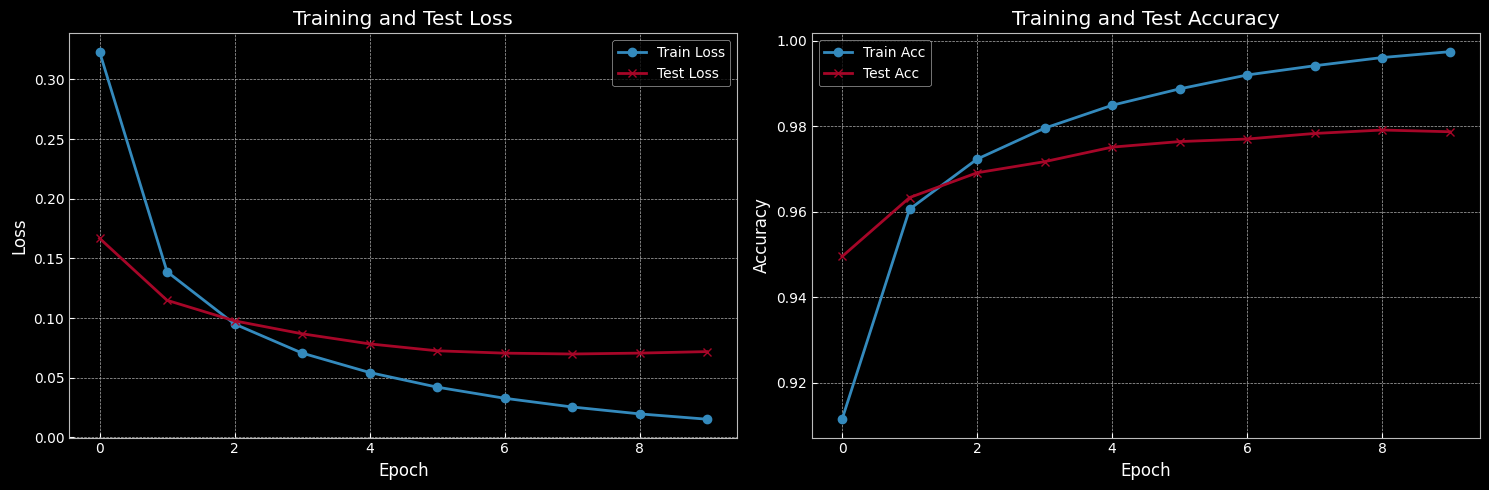

In [25]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['test_loss'], label='Test Loss', marker='x')
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(history['test_acc'], label='Test Acc', marker='x')
    ax2.set_title('Training and Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)